#CapsGAN
### A genreative Adversarial Network using a Capsule Network (CapsNet) as a discriminator

##References
####Dynamic Routing Between Capsules, Sara Sabour et al.    https://arxiv.org/pdf/1710.09829.pdf
#### Capsule Networks (CapsNets), Aurélien Geron     https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb
####CapsuleNet on MNIST,  Kevin Mader      https://www.kaggle.com/kmader/capsulenet-on-mnist
###capsule-GAN,  Guseyn Gadirov           https://github.com/gusgad/capsule-GAN/blob/master/capsule_gan.ipynb

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import Graph, Session
import keras.backend as K
from keras import backend as K
from keras import Sequential, models, layers

import keras
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer, Input
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras import initializers
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Lambda, Concatenate, Multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam


%matplotlib inline

Using TensorFlow backend.


##Squash helper function

In [0]:
def squash(vector, axis=-1, epsilon=1e-7):
    
    s_squared_norm = K.sum(K.square(vector), axis, keepdims=True)
    safe_norm =  K.sqrt(s_squared_norm + epsilon)
    squash_factor = s_squared_norm / (1.0 + s_squared_norm)
    unit_vector = vector / safe_norm
    
    return squash_factor * unit_vector


## Primary Capsules Layer

In [0]:
def primaryCaps(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    '''
    inputs : output of first convolutional layer of shape (?x20x20x256)
    dim_vector : the dimension of the output vector of each capsule = 8
    n_channels : the number of different capsules = 32 
    
    output : output of the convultional layer reshaped to ?x1152x8 and squash function applied to it
    
    '''
    
    conv2 = Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    out = layers.Reshape(target_shape=[-1, dim_vector])(conv2)
    
    return layers.Lambda(squash)(out)


#Building the CapsNet discriminator
##This implementation uses dense layers as a replacement for the conventional Digit Capsules layer

In [0]:
def build_capsNet():
    
    
    #input shape of the mnist image
    input_shape=(28,28,1)
    
    #this capsnet only has 1 class as it only needs to distinguish if the image is real or fake
    num_classes=1
    
    
    #the image input to the model
    x_in = layers.Input(shape=input_shape)
    
    
    #first concolutional layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(x_in)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = BatchNormalization(momentum=0.8)(conv1)

    
    # primary capsules layer
    prim = primaryCaps(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    prim = BatchNormalization(momentum=0.8)(prim)

    
    # Digit capsules layer implemented as normal dense layers
    x = Flatten()(prim)
    
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    c = Activation('softmax', name='softmax_digitcaps1')(uhat)
    c = Dense(160)(c)
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)
    
    
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) 
    c = Dense(160)(c) 
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) 
    c = Dense(160)(c) 
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)
    
    
    pred = Dense(1, activation='sigmoid')(s_j)

    
    model = models.Model(x_in , pred)
    #model.compile(loss=margin_loss, optimizer=Adam(0.0002, 0.5),metrics={'pred': 'accuracy'})
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    
    return model


##Defining the margin loss
###used for calculating the loss of the CapsNet


In [0]:
def margin_loss(y_true, y_pred):
    
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [6]:
# Define the model
discriminator = build_capsNet()
discriminator.summary()

W0805 17:03:46.793862 140105437140864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 17:03:46.818551 140105437140864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 17:03:46.823836 140105437140864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 17:03:46.859152 140105437140864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 17:03:46.863372 1401054371

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 20, 20, 256)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 20, 256)  1024        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_1 (

### Load the mnist dataset

In [7]:
from keras.datasets import mnist

def load_data():
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_test = (x_test.astype(np.float32) - 127.5)/127.5
    
    x_train = x_train.reshape(-1,28,28,1)
    x_test = x_test.reshape(-1,28,28,1)
    
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    
    return (x_train, y_train, x_test, y_test)


(x_train, y_train,x_test, y_test)=load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


##Building the Generator model
###The generator's architecture is the same as of the architecture of a regular Deep Convolutional GAN - DCGAN

In [0]:
def build_generator():
    
    noise_shape = (100,)
    x_noise = Input(shape=noise_shape)
    
    x = Dense(128*7*7, activation="relu")(x_noise)
    x = Reshape((7, 7, 128))(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    x_out = Activation('tanh')(x)
    
    model = models.Model(x_noise, x_out)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    
    
    return model


In [9]:
generator = build_generator()
generator.summary()

W0805 17:03:49.147365 140105437140864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
__________

### Function to plot the generated images

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

##Defining the Adversarial model

In [0]:
def create_gan(g, d):
    
    z = Input(shape=[100])
    img = g(z)
    v = d(g(z))
    
    gan = models.Model(z, v)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    
    return gan

In [12]:
gan = create_gan(generator, discriminator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         856193    
_________________________________________________________________
model_1 (Model)              (None, 1)                 6882881   
Total params: 7,739,074
Trainable params: 7,738,162
Non-trainable params: 912
_________________________________________________________________


#Training the model

In [0]:
def train(data, epochs, batch_size=128):
    
    #unpack data
    x_train = data
    
    K.clear_session()
    
    gen = build_generator()
    disc = build_capsNet()
    gan = create_gan(gen, disc)
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    
    for e in range(epochs+1):
        
        real_indxs = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[real_indxs]
        
        noise = np.random.normal(0,1, [batch_size, 100])
        gen_imgs = gen.predict(noise)
        
        x = np.concatenate([real_imgs, gen_imgs])
        y = np.concatenate([valid, fake])
        
        #Training the Discriminator
        disc.Trainable = True
        
        d_loss_real = disc.train_on_batch(real_imgs, valid*0.9) # 0.9 for label smoothing
        d_loss_fake = disc.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #Training the generator 
        disc.Trainable = False
        
        noise = np.random.normal(0,1, [batch_size, 100])
        y_gan = np.ones((batch_size, 1))
        
        g_loss = gan.train_on_batch((noise), [y_gan])
        
        if e%100 == 0:
          
          #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, d_loss, 100*d_loss, g_loss))
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, d_loss[0], 100*d_loss[1], g_loss))
        
        if e % 1000 == 0:
            plot_generated_images(e, gen)

0 [D loss: 0.692452, acc.: 25.78%] [G loss: 0.703323]
100 [D loss: 0.690022, acc.: 0.00%] [G loss: 0.543523]
200 [D loss: 0.653430, acc.: 0.00%] [G loss: 0.559143]
300 [D loss: 0.663862, acc.: 0.39%] [G loss: 0.576408]
400 [D loss: 0.678835, acc.: 0.00%] [G loss: 0.527379]
500 [D loss: 0.757925, acc.: 0.00%] [G loss: 0.502246]
600 [D loss: 0.754791, acc.: 0.00%] [G loss: 0.482153]
700 [D loss: 0.771630, acc.: 0.78%] [G loss: 0.478499]
800 [D loss: 0.775678, acc.: 1.17%] [G loss: 0.474733]
900 [D loss: 0.806840, acc.: 0.00%] [G loss: 0.446639]
1000 [D loss: 0.787823, acc.: 0.39%] [G loss: 0.439376]
1100 [D loss: 0.789819, acc.: 0.00%] [G loss: 0.431329]
1200 [D loss: 0.785772, acc.: 0.00%] [G loss: 0.429723]
1300 [D loss: 0.818520, acc.: 0.00%] [G loss: 0.450631]
1400 [D loss: 0.793129, acc.: 0.00%] [G loss: 0.437919]
1500 [D loss: 0.838765, acc.: 0.39%] [G loss: 0.416567]
1600 [D loss: 0.813028, acc.: 0.78%] [G loss: 0.427587]
1700 [D loss: 0.781254, acc.: 0.00%] [G loss: 0.438877]
180

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20100 [D loss: 0.759187, acc.: 6.25%] [G loss: 1.003588]
20200 [D loss: 0.755007, acc.: 6.64%] [G loss: 1.014826]
20300 [D loss: 0.745500, acc.: 6.64%] [G loss: 1.040226]
20400 [D loss: 0.766783, acc.: 6.25%] [G loss: 0.973588]
20500 [D loss: 0.775017, acc.: 3.12%] [G loss: 1.040720]
20600 [D loss: 0.730953, acc.: 5.86%] [G loss: 1.023584]
20700 [D loss: 0.722273, acc.: 5.86%] [G loss: 1.077883]
20800 [D loss: 0.759717, acc.: 6.64%] [G loss: 0.992814]
20900 [D loss: 0.762302, acc.: 6.64%] [G loss: 1.089961]
21000 [D loss: 0.676326, acc.: 14.45%] [G loss: 1.151305]
21100 [D loss: 0.722197, acc.: 9.38%] [G loss: 1.161070]
21200 [D loss: 0.839579, acc.: 7.42%] [G loss: 1.716116]
21300 [D loss: 0.798894, acc.: 16.80%] [G loss: 1.737913]
21400 [D loss: 0.712865, acc.: 21.09%] [G loss: 2.021316]
21500 [D loss: 0.675401, acc.: 18.75%] [G loss: 2.071393]
21600 [D loss: 0.511029, acc.: 30.86%] [G loss: 1.846537]
21700 [D loss: 0.447515, acc.: 39.45%] [G loss: 1.776464]
21800 [D loss: 0.500594, 

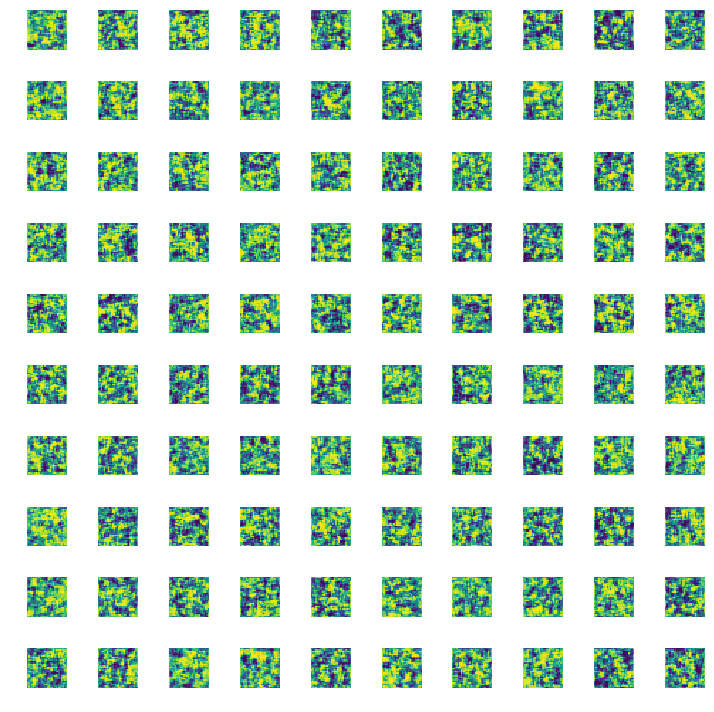

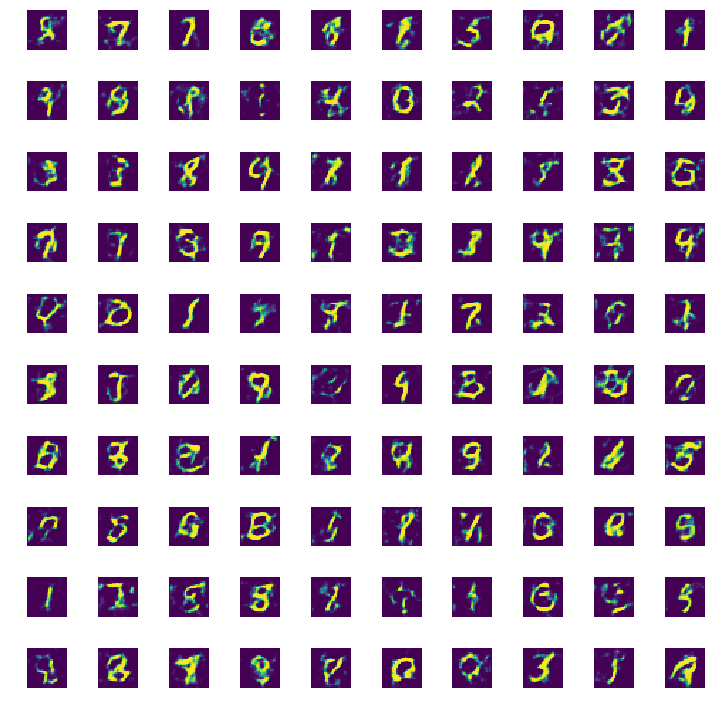

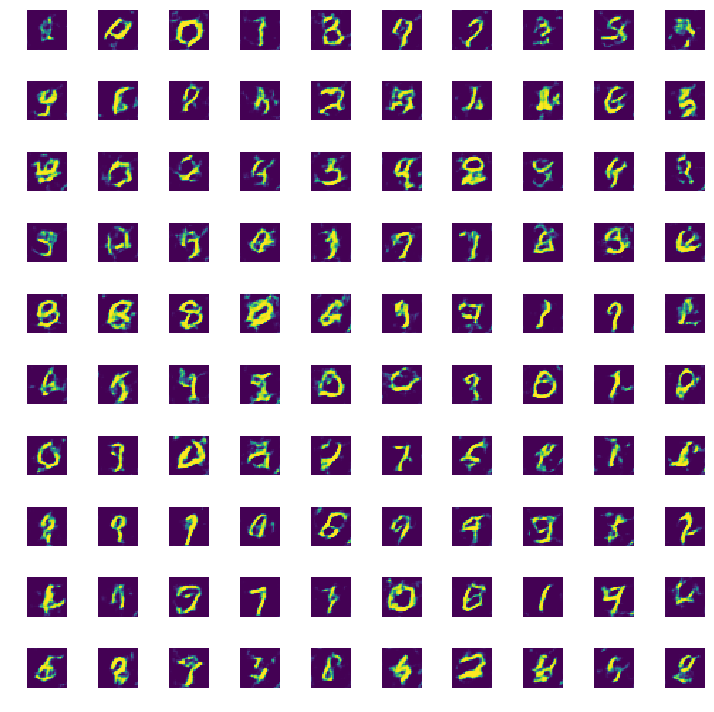

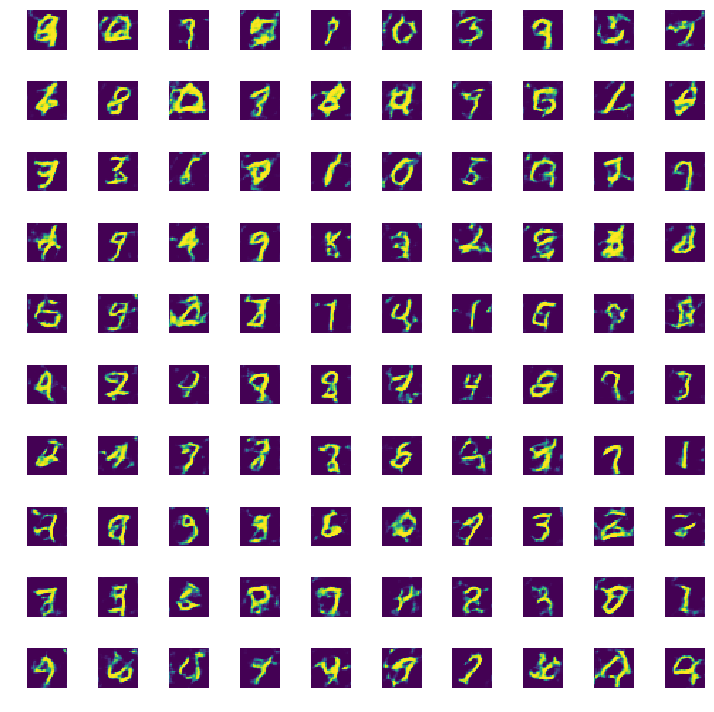

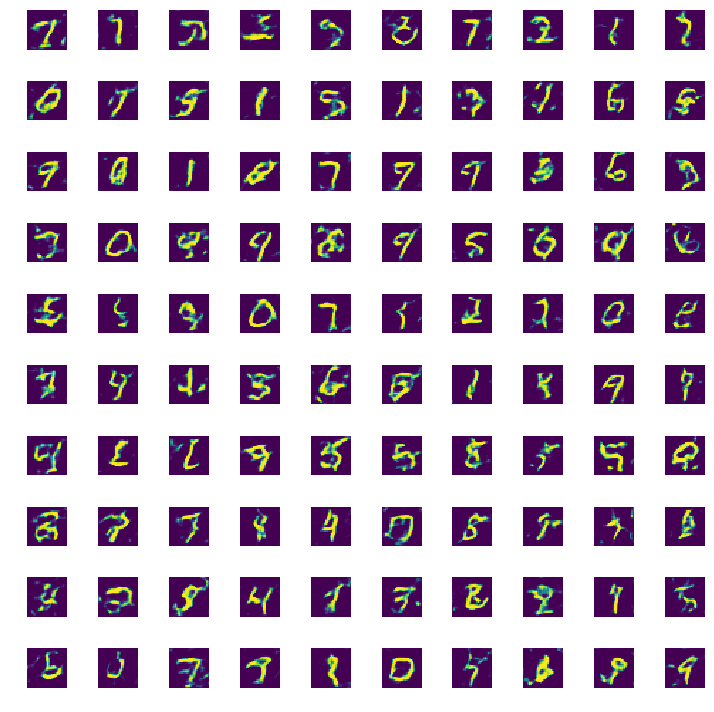

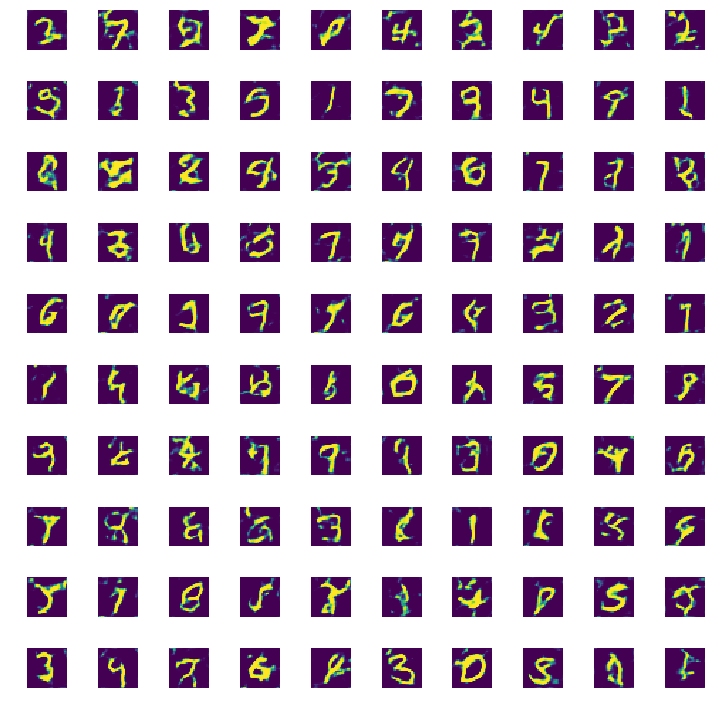

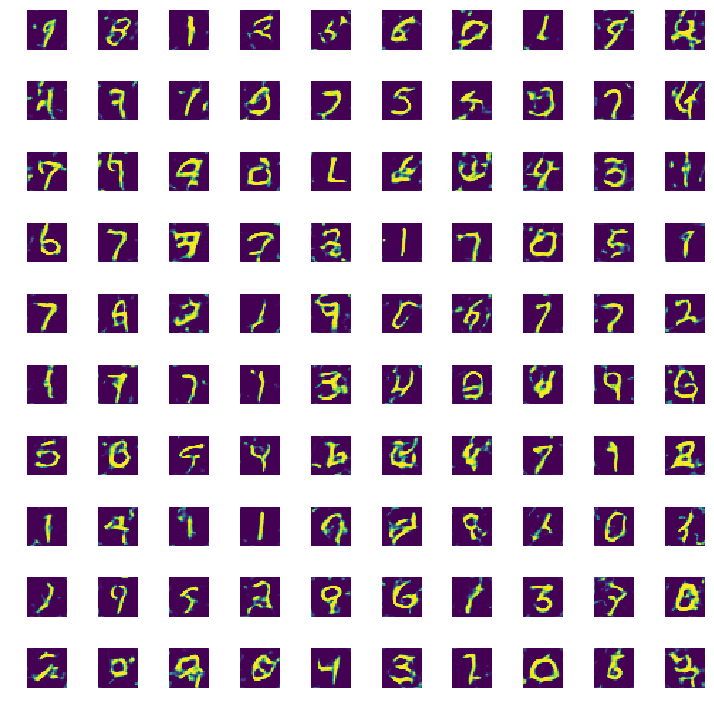

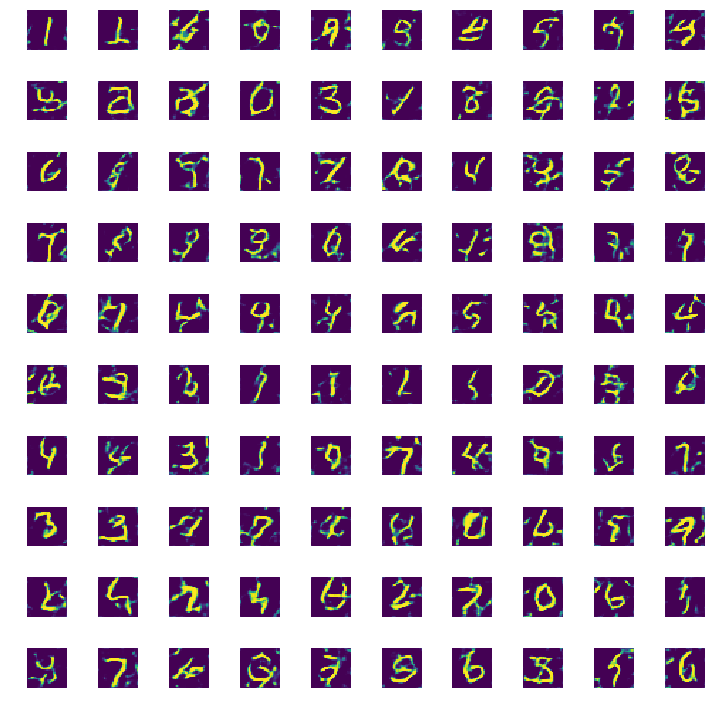

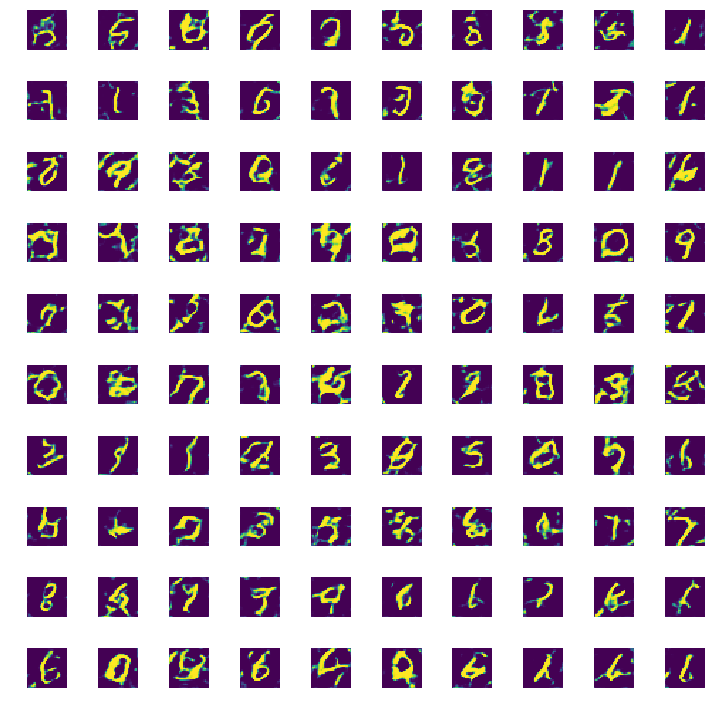

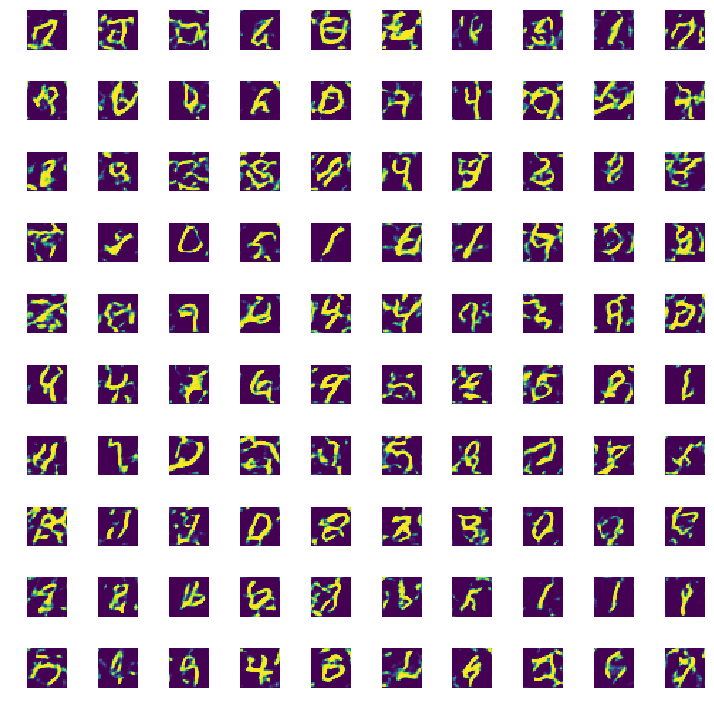

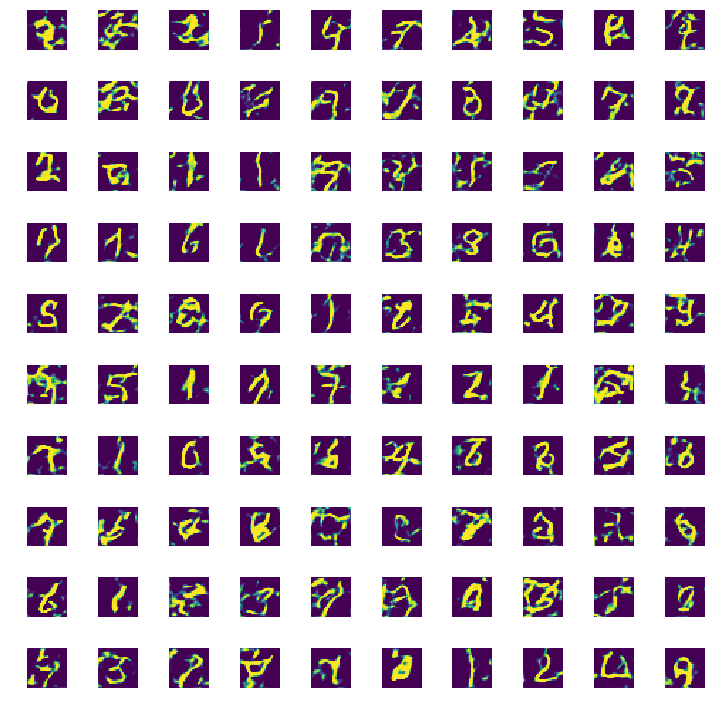

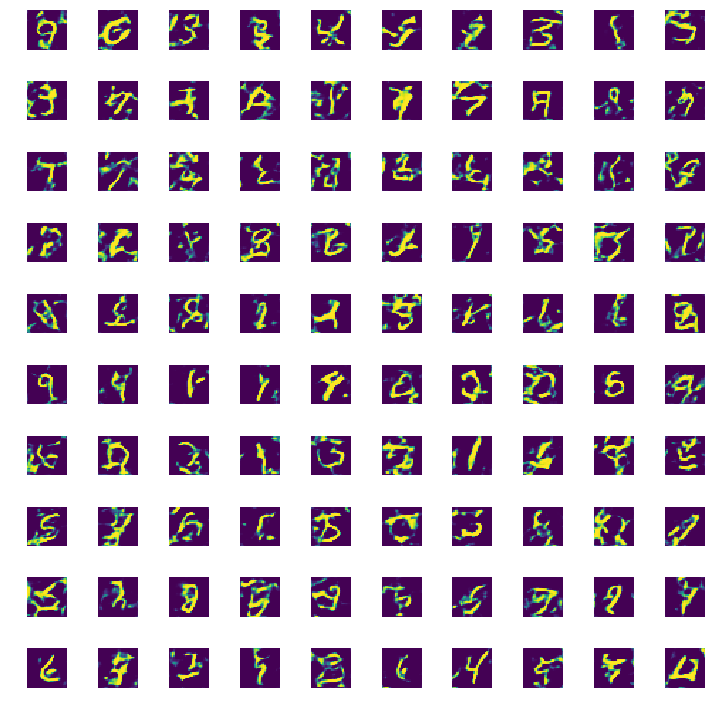

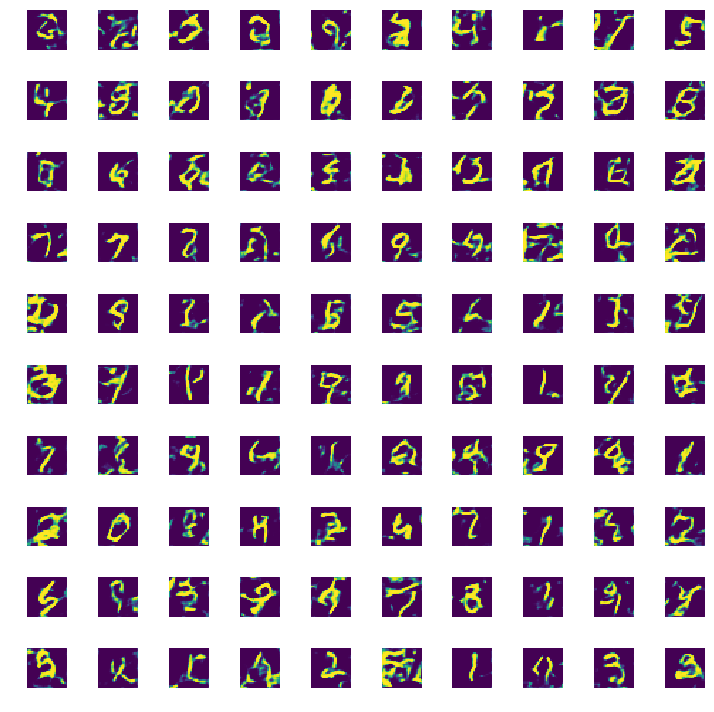

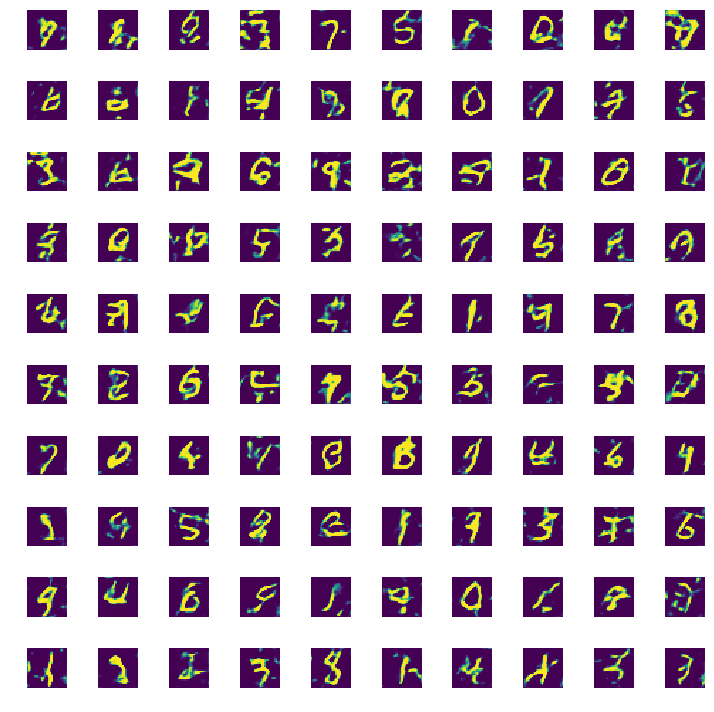

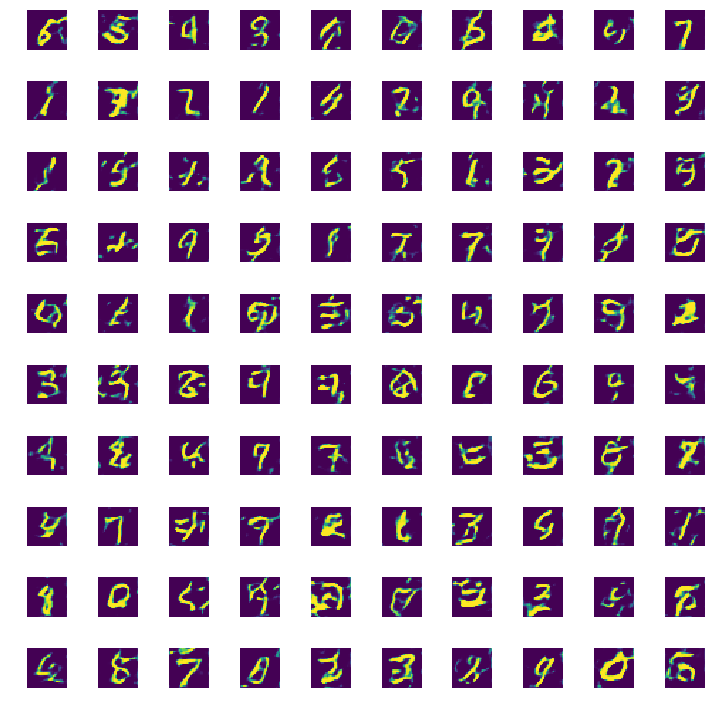

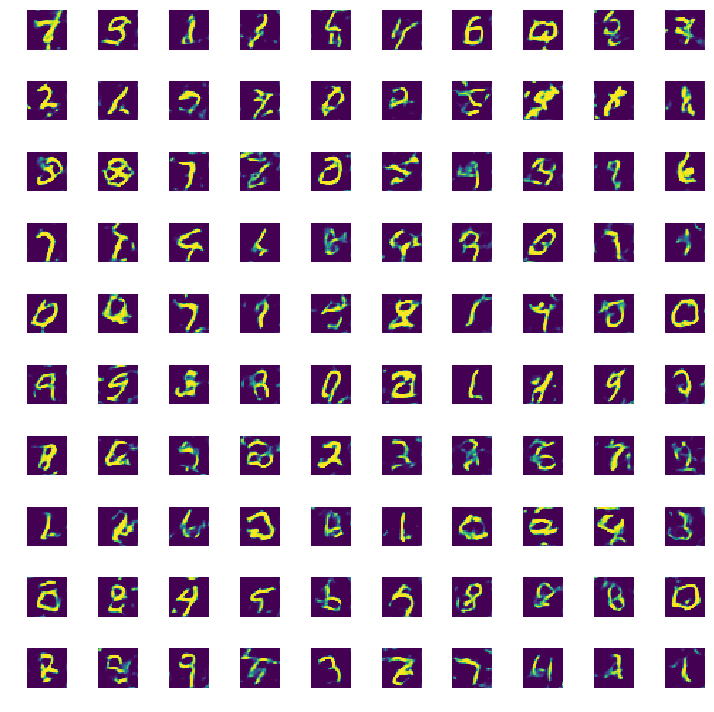

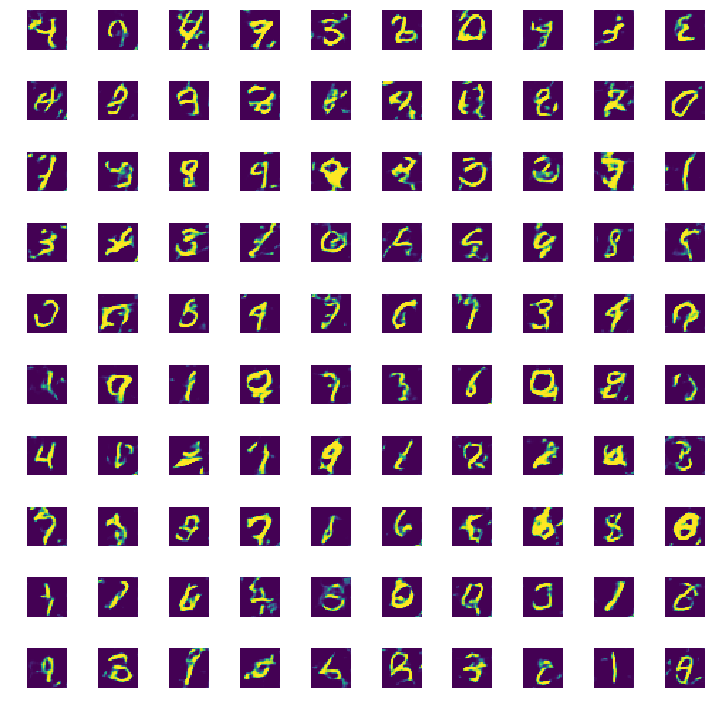

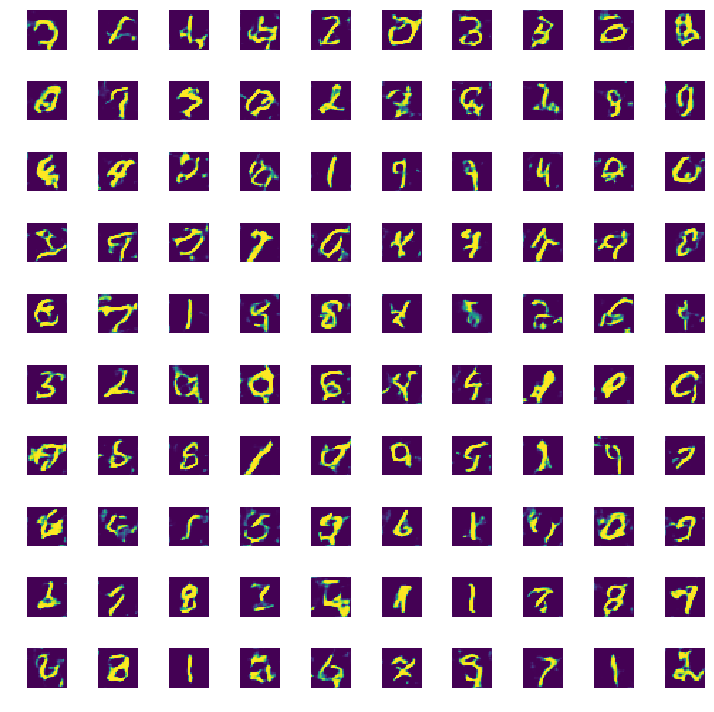

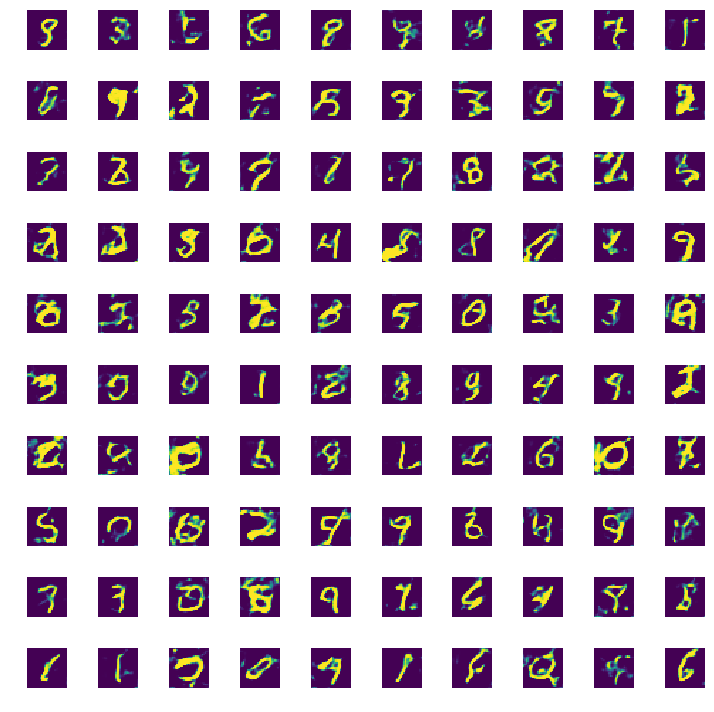

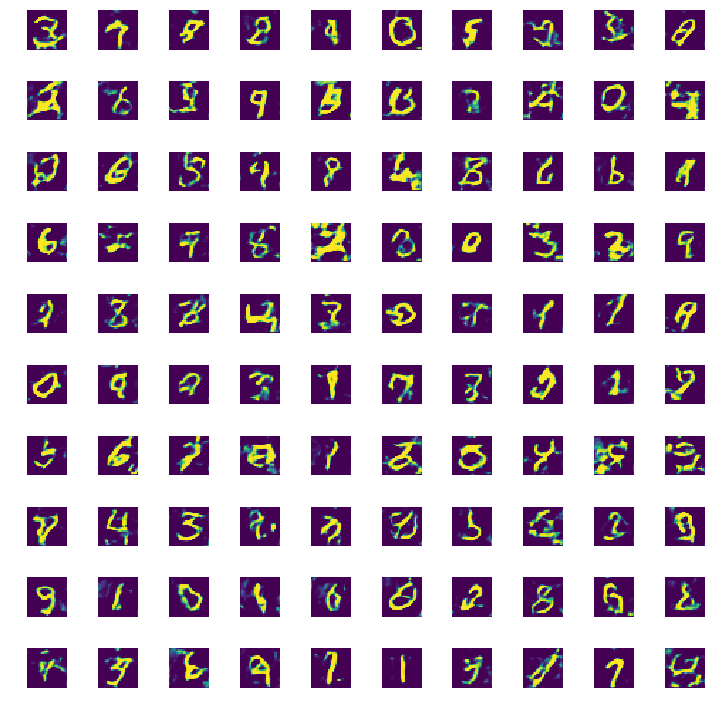

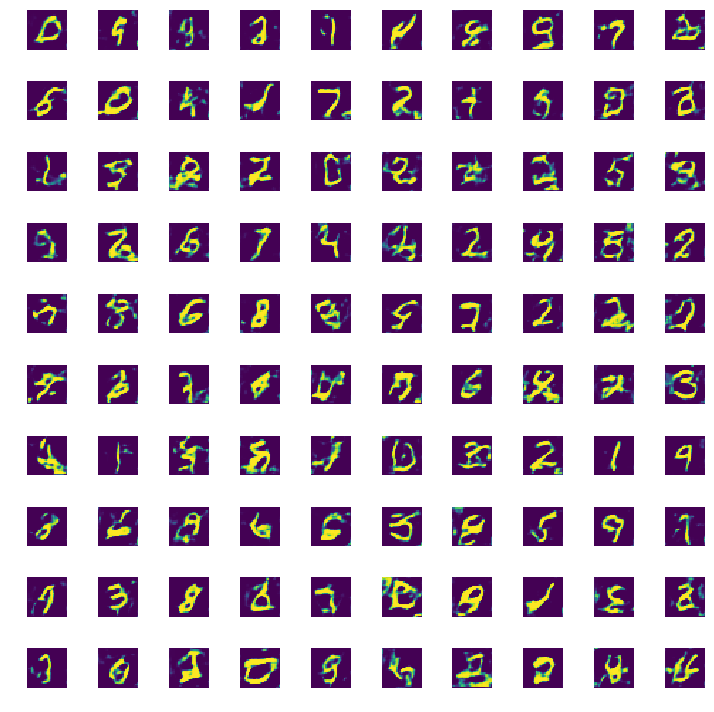

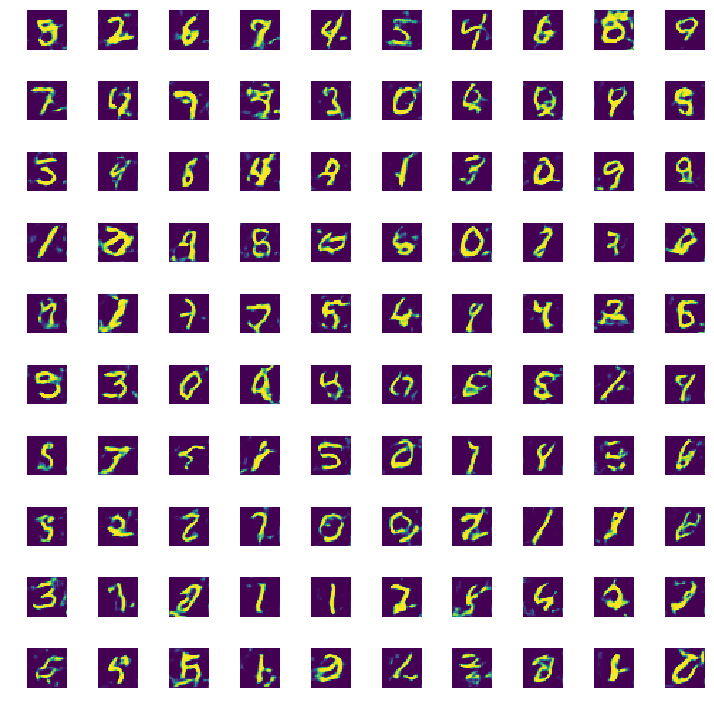

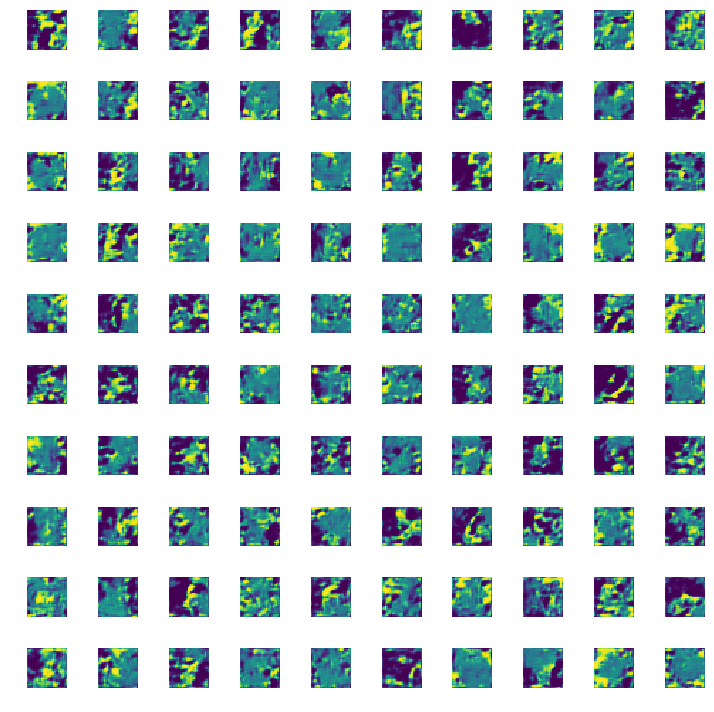

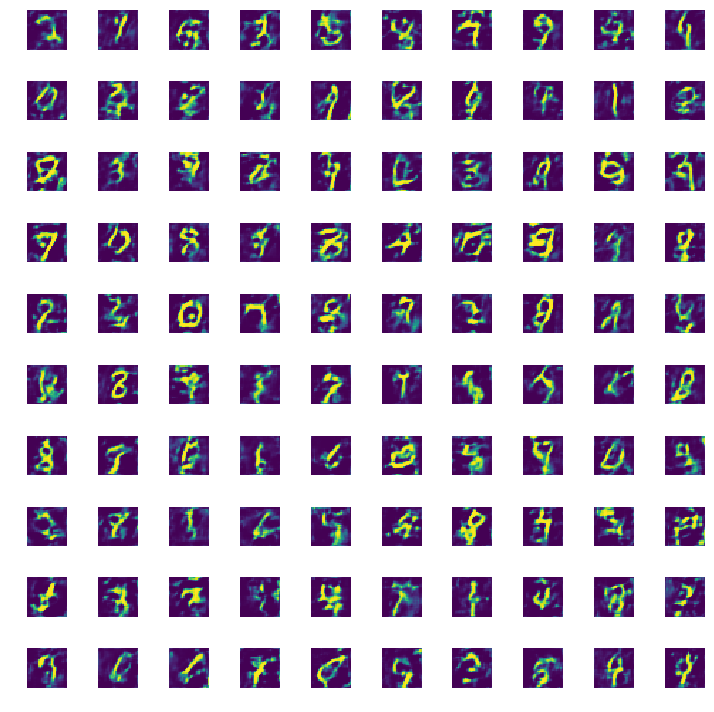

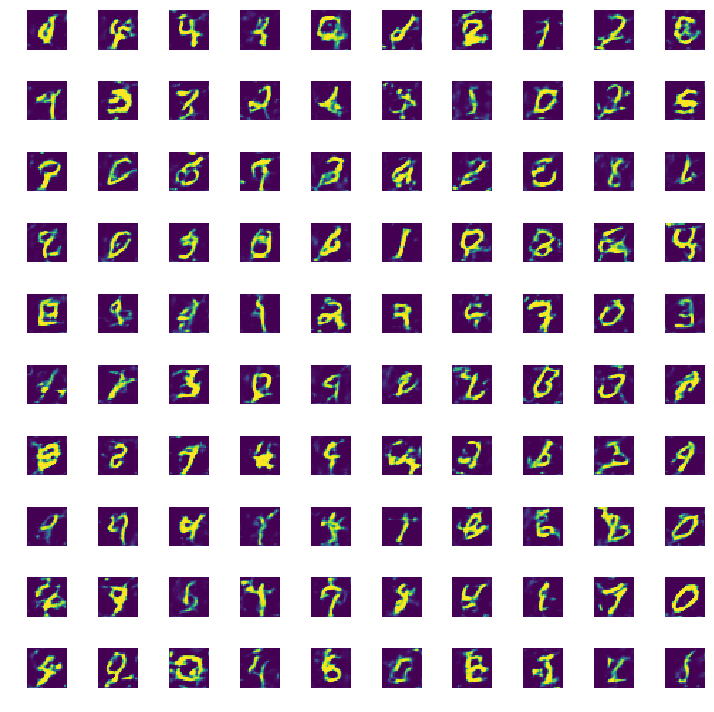

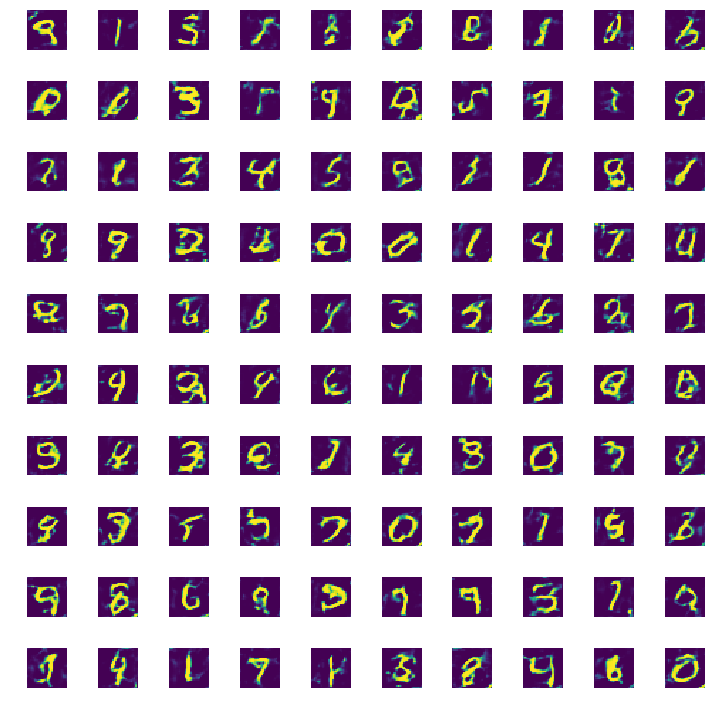

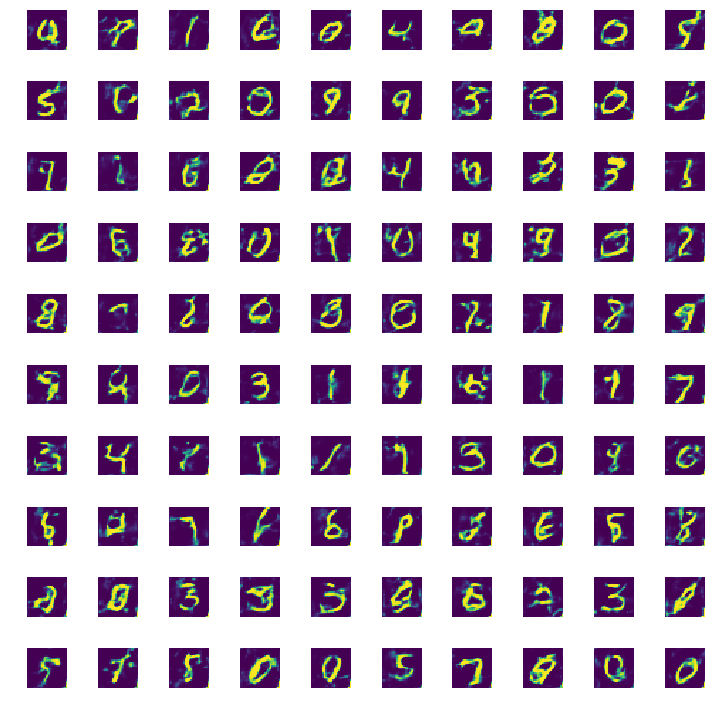

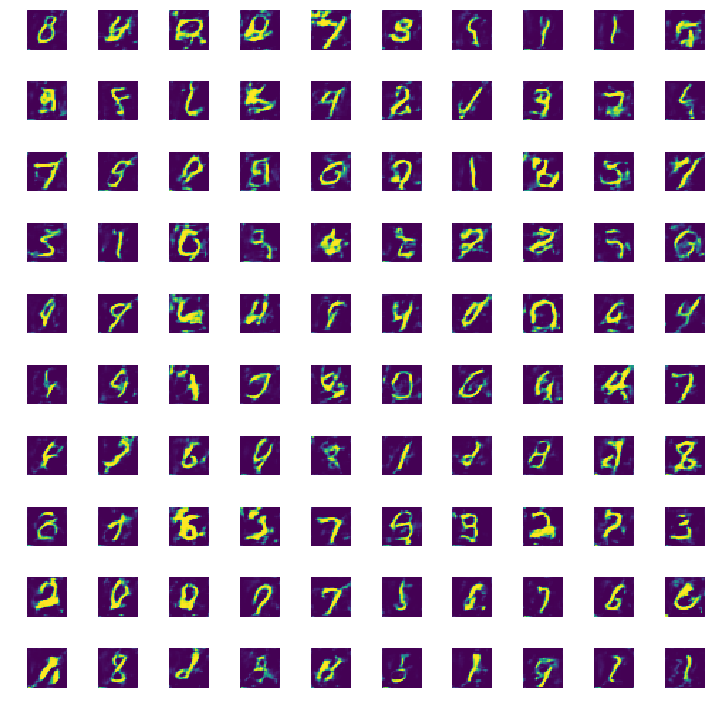

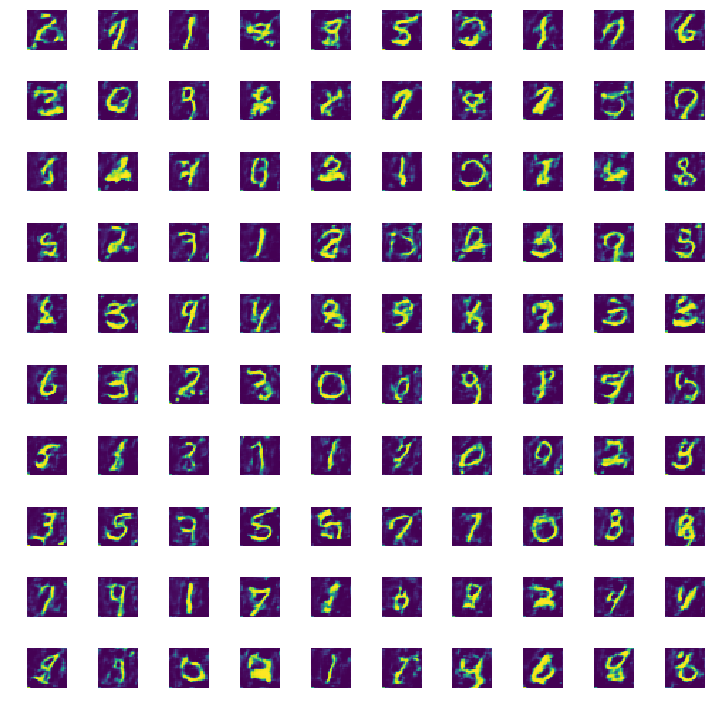

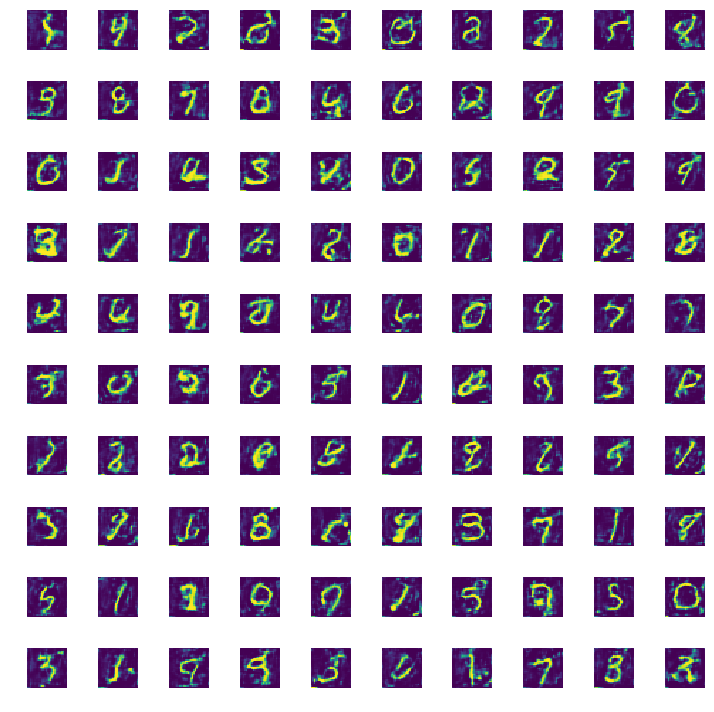

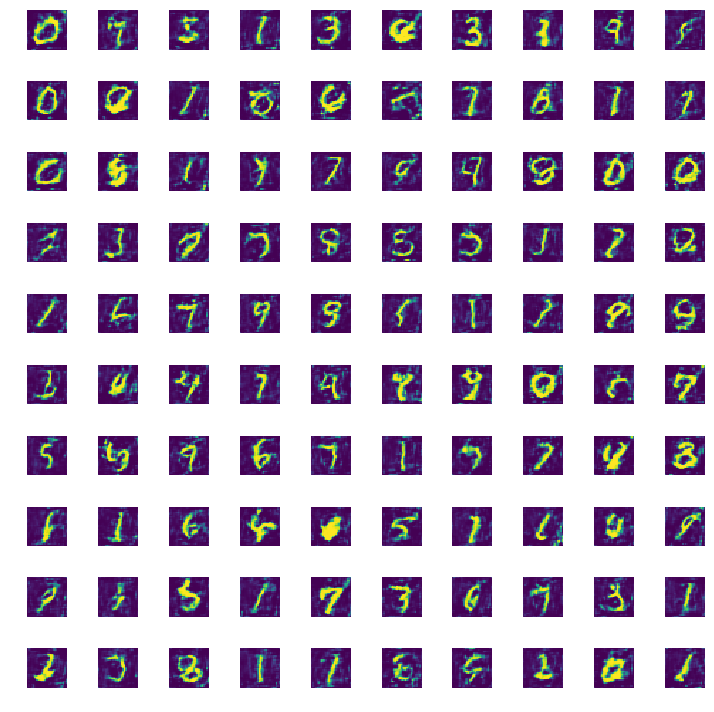

In [14]:
train(x_train, epochs=30000)